<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[22:07:11] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


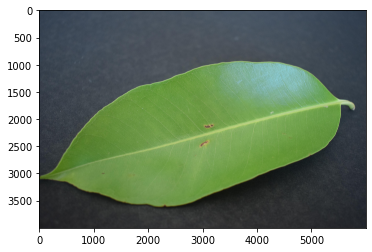

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

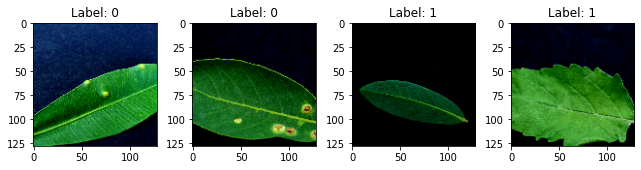

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[22:07:18] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[22:07:20] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.249385889724516 samples/sec                   batch loss = 0.5390316843986511 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2602720010107886 samples/sec                   batch loss = 0.6288560628890991 | accuracy = 0.425


Epoch[1] Batch[15] Speed: 1.2634978535423236 samples/sec                   batch loss = 0.8687039613723755 | accuracy = 0.45


Epoch[1] Batch[20] Speed: 1.2618910280830884 samples/sec                   batch loss = 0.7171054482460022 | accuracy = 0.4625


Epoch[1] Batch[25] Speed: 1.2632135008882361 samples/sec                   batch loss = 0.6216533184051514 | accuracy = 0.51


Epoch[1] Batch[30] Speed: 1.2640486572227014 samples/sec                   batch loss = 1.052588939666748 | accuracy = 0.55


Epoch[1] Batch[35] Speed: 1.2691907883822386 samples/sec                   batch loss = 0.641481339931488 | accuracy = 0.5785714285714286


Epoch[1] Batch[40] Speed: 1.2665374352603649 samples/sec                   batch loss = 0.5056610107421875 | accuracy = 0.6


Epoch[1] Batch[45] Speed: 1.2662192201255698 samples/sec                   batch loss = 0.1991397887468338 | accuracy = 0.6166666666666667


Epoch[1] Batch[50] Speed: 1.2659171163568617 samples/sec                   batch loss = 1.781697392463684 | accuracy = 0.61


Epoch[1] Batch[55] Speed: 1.2616003777909457 samples/sec                   batch loss = 0.4416229724884033 | accuracy = 0.6090909090909091


Epoch[1] Batch[60] Speed: 1.266917227655004 samples/sec                   batch loss = 0.9303017854690552 | accuracy = 0.6041666666666666


Epoch[1] Batch[65] Speed: 1.2632905460067672 samples/sec                   batch loss = 0.6791847944259644 | accuracy = 0.6


Epoch[1] Batch[70] Speed: 1.2628004710620921 samples/sec                   batch loss = 0.8350566625595093 | accuracy = 0.5892857142857143


Epoch[1] Batch[75] Speed: 1.2648548798064074 samples/sec                   batch loss = 1.0027670860290527 | accuracy = 0.5966666666666667


Epoch[1] Batch[80] Speed: 1.2678946780547238 samples/sec                   batch loss = 0.5884081721305847 | accuracy = 0.60625


Epoch[1] Batch[85] Speed: 1.265637402456951 samples/sec                   batch loss = 0.837957501411438 | accuracy = 0.5970588235294118


Epoch[1] Batch[90] Speed: 1.2676675346114419 samples/sec                   batch loss = 0.8042798042297363 | accuracy = 0.6027777777777777


Epoch[1] Batch[95] Speed: 1.2672351237371904 samples/sec                   batch loss = 0.7688989639282227 | accuracy = 0.6026315789473684


Epoch[1] Batch[100] Speed: 1.262876705317006 samples/sec                   batch loss = 0.2640281915664673 | accuracy = 0.6125


Epoch[1] Batch[105] Speed: 1.266781007967774 samples/sec                   batch loss = 0.7946438193321228 | accuracy = 0.6142857142857143


Epoch[1] Batch[110] Speed: 1.2626428987505438 samples/sec                   batch loss = 1.5658680200576782 | accuracy = 0.6204545454545455


Epoch[1] Batch[115] Speed: 1.2696851642108535 samples/sec                   batch loss = 0.4349389374256134 | accuracy = 0.6195652173913043


Epoch[1] Batch[120] Speed: 1.2664642000687234 samples/sec                   batch loss = 0.7432229518890381 | accuracy = 0.6229166666666667


Epoch[1] Batch[125] Speed: 1.2656886756760732 samples/sec                   batch loss = 0.35117989778518677 | accuracy = 0.628


Epoch[1] Batch[130] Speed: 1.2674658465904838 samples/sec                   batch loss = 1.2755327224731445 | accuracy = 0.6288461538461538


Epoch[1] Batch[135] Speed: 1.2718791941831362 samples/sec                   batch loss = 0.7632555365562439 | accuracy = 0.6277777777777778


Epoch[1] Batch[140] Speed: 1.2625270730195108 samples/sec                   batch loss = 0.5750005841255188 | accuracy = 0.6267857142857143


Epoch[1] Batch[145] Speed: 1.2680544265504217 samples/sec                   batch loss = 0.7240979075431824 | accuracy = 0.6224137931034482


Epoch[1] Batch[150] Speed: 1.2673630161537037 samples/sec                   batch loss = 0.7917245030403137 | accuracy = 0.625


Epoch[1] Batch[155] Speed: 1.2714282964444268 samples/sec                   batch loss = 0.29452061653137207 | accuracy = 0.6290322580645161


Epoch[1] Batch[160] Speed: 1.268269436619548 samples/sec                   batch loss = 1.2527738809585571 | accuracy = 0.63125


Epoch[1] Batch[165] Speed: 1.2669236375894433 samples/sec                   batch loss = 0.4105110466480255 | accuracy = 0.6393939393939394


Epoch[1] Batch[170] Speed: 1.2678031786031856 samples/sec                   batch loss = 0.695130467414856 | accuracy = 0.6411764705882353


Epoch[1] Batch[175] Speed: 1.2717403630352428 samples/sec                   batch loss = 1.0302056074142456 | accuracy = 0.6414285714285715


Epoch[1] Batch[180] Speed: 1.2687974455277564 samples/sec                   batch loss = 0.5254969000816345 | accuracy = 0.6375


Epoch[1] Batch[185] Speed: 1.2699190871293915 samples/sec                   batch loss = 0.9240057468414307 | accuracy = 0.6405405405405405


Epoch[1] Batch[190] Speed: 1.269066270624047 samples/sec                   batch loss = 0.9429572224617004 | accuracy = 0.6434210526315789


Epoch[1] Batch[195] Speed: 1.2666488340027378 samples/sec                   batch loss = 0.3015795052051544 | accuracy = 0.65


Epoch[1] Batch[200] Speed: 1.2674464090185844 samples/sec                   batch loss = 0.5129035711288452 | accuracy = 0.65125


Epoch[1] Batch[205] Speed: 1.2698619919917298 samples/sec                   batch loss = 0.34901198744773865 | accuracy = 0.6524390243902439


Epoch[1] Batch[210] Speed: 1.2717215653139282 samples/sec                   batch loss = 0.5133043527603149 | accuracy = 0.6523809523809524


Epoch[1] Batch[215] Speed: 1.266311924758023 samples/sec                   batch loss = 1.2264962196350098 | accuracy = 0.6546511627906977


Epoch[1] Batch[220] Speed: 1.2688236416078043 samples/sec                   batch loss = 0.8562098145484924 | accuracy = 0.6545454545454545


Epoch[1] Batch[225] Speed: 1.2685463826667547 samples/sec                   batch loss = 0.44815972447395325 | accuracy = 0.6555555555555556


Epoch[1] Batch[230] Speed: 1.2704716564353251 samples/sec                   batch loss = 0.47649946808815 | accuracy = 0.658695652173913


Epoch[1] Batch[235] Speed: 1.2660997754073415 samples/sec                   batch loss = 0.8025249242782593 | accuracy = 0.6574468085106383


Epoch[1] Batch[240] Speed: 1.2698574745821736 samples/sec                   batch loss = 1.0282549858093262 | accuracy = 0.659375


Epoch[1] Batch[245] Speed: 1.275556688896056 samples/sec                   batch loss = 0.9240897297859192 | accuracy = 0.6602040816326531


Epoch[1] Batch[250] Speed: 1.2722321931493108 samples/sec                   batch loss = 0.5456968545913696 | accuracy = 0.665


Epoch[1] Batch[255] Speed: 1.2699508088688463 samples/sec                   batch loss = 0.8368029594421387 | accuracy = 0.6676470588235294


Epoch[1] Batch[260] Speed: 1.268542066444073 samples/sec                   batch loss = 0.19533492624759674 | accuracy = 0.6673076923076923


Epoch[1] Batch[265] Speed: 1.2706995172509798 samples/sec                   batch loss = 0.3739089369773865 | accuracy = 0.6698113207547169


Epoch[1] Batch[270] Speed: 1.2640512286386607 samples/sec                   batch loss = 0.5737735033035278 | accuracy = 0.6685185185185185


Epoch[1] Batch[275] Speed: 1.2671766426180378 samples/sec                   batch loss = 0.2940449118614197 | accuracy = 0.6727272727272727


Epoch[1] Batch[280] Speed: 1.2742281950251133 samples/sec                   batch loss = 0.37283408641815186 | accuracy = 0.6714285714285714


Epoch[1] Batch[285] Speed: 1.2727825291244732 samples/sec                   batch loss = 0.31100988388061523 | accuracy = 0.6745614035087719


Epoch[1] Batch[290] Speed: 1.2665426939877629 samples/sec                   batch loss = 0.651301920413971 | accuracy = 0.6715517241379311


Epoch[1] Batch[295] Speed: 1.2677365025053284 samples/sec                   batch loss = 1.1260097026824951 | accuracy = 0.6720338983050848


Epoch[1] Batch[300] Speed: 1.2670053460185793 samples/sec                   batch loss = 0.515105664730072 | accuracy = 0.6708333333333333


Epoch[1] Batch[305] Speed: 1.271223483621227 samples/sec                   batch loss = 0.5721064209938049 | accuracy = 0.669672131147541


Epoch[1] Batch[310] Speed: 1.2708772053151178 samples/sec                   batch loss = 0.23123234510421753 | accuracy = 0.6685483870967742


Epoch[1] Batch[315] Speed: 1.2658852137501568 samples/sec                   batch loss = 0.7484912872314453 | accuracy = 0.6682539682539682


Epoch[1] Batch[320] Speed: 1.2652495983221725 samples/sec                   batch loss = 0.4429296553134918 | accuracy = 0.665625


Epoch[1] Batch[325] Speed: 1.2672322521978006 samples/sec                   batch loss = 0.293854683637619 | accuracy = 0.6676923076923077


Epoch[1] Batch[330] Speed: 1.272363508595984 samples/sec                   batch loss = 0.3912017047405243 | accuracy = 0.6696969696969697


Epoch[1] Batch[335] Speed: 1.2713641287907034 samples/sec                   batch loss = 0.2687080502510071 | accuracy = 0.6708955223880597


Epoch[1] Batch[340] Speed: 1.2705367924224669 samples/sec                   batch loss = 0.4185308814048767 | accuracy = 0.6735294117647059


Epoch[1] Batch[345] Speed: 1.267707286023029 samples/sec                   batch loss = 0.25449830293655396 | accuracy = 0.6753623188405797


Epoch[1] Batch[350] Speed: 1.268633001077307 samples/sec                   batch loss = 0.48727041482925415 | accuracy = 0.6735714285714286


Epoch[1] Batch[355] Speed: 1.2671565439707555 samples/sec                   batch loss = 0.5855240821838379 | accuracy = 0.6732394366197183


Epoch[1] Batch[360] Speed: 1.2734124958586353 samples/sec                   batch loss = 0.35598233342170715 | accuracy = 0.6722222222222223


Epoch[1] Batch[365] Speed: 1.2677258694657378 samples/sec                   batch loss = 0.6597403883934021 | accuracy = 0.6719178082191781


Epoch[1] Batch[370] Speed: 1.2646884049761007 samples/sec                   batch loss = 0.5683416128158569 | accuracy = 0.6736486486486486


Epoch[1] Batch[375] Speed: 1.265365733278185 samples/sec                   batch loss = 0.7232185006141663 | accuracy = 0.6746666666666666


Epoch[1] Batch[380] Speed: 1.2641309477228266 samples/sec                   batch loss = 0.6892837285995483 | accuracy = 0.675


Epoch[1] Batch[385] Speed: 1.267208036066586 samples/sec                   batch loss = 0.5317385196685791 | accuracy = 0.674025974025974


Epoch[1] Batch[390] Speed: 1.2739343494506443 samples/sec                   batch loss = 0.5102953314781189 | accuracy = 0.6730769230769231


Epoch[1] Batch[395] Speed: 1.264225823678448 samples/sec                   batch loss = 1.3918901681900024 | accuracy = 0.6721518987341772


Epoch[1] Batch[400] Speed: 1.2672932273464717 samples/sec                   batch loss = 0.8015460968017578 | accuracy = 0.670625


Epoch[1] Batch[405] Speed: 1.2697359971537452 samples/sec                   batch loss = 0.7824679017066956 | accuracy = 0.6728395061728395


Epoch[1] Batch[410] Speed: 1.2670246743780202 samples/sec                   batch loss = 0.4588926434516907 | accuracy = 0.6731707317073171


Epoch[1] Batch[415] Speed: 1.2720474711662464 samples/sec                   batch loss = 0.8071120381355286 | accuracy = 0.6740963855421687


Epoch[1] Batch[420] Speed: 1.2673756536320606 samples/sec                   batch loss = 0.6996363997459412 | accuracy = 0.674404761904762


Epoch[1] Batch[425] Speed: 1.2688034906809902 samples/sec                   batch loss = 0.818895697593689 | accuracy = 0.6747058823529412


Epoch[1] Batch[430] Speed: 1.2664716570508054 samples/sec                   batch loss = 0.4346548318862915 | accuracy = 0.6755813953488372


Epoch[1] Batch[435] Speed: 1.269454593275072 samples/sec                   batch loss = 0.6190816164016724 | accuracy = 0.6741379310344827


Epoch[1] Batch[440] Speed: 1.262296719951751 samples/sec                   batch loss = 0.2937381863594055 | accuracy = 0.6727272727272727


Epoch[1] Batch[445] Speed: 1.2645469453523317 samples/sec                   batch loss = 0.5557132959365845 | accuracy = 0.6724719101123595


Epoch[1] Batch[450] Speed: 1.2657262022848415 samples/sec                   batch loss = 0.9330540299415588 | accuracy = 0.6738888888888889


Epoch[1] Batch[455] Speed: 1.268952334764331 samples/sec                   batch loss = 0.5159502625465393 | accuracy = 0.6752747252747253


Epoch[1] Batch[460] Speed: 1.2649128607117182 samples/sec                   batch loss = 0.5387451648712158 | accuracy = 0.6766304347826086


Epoch[1] Batch[465] Speed: 1.263763390262089 samples/sec                   batch loss = 0.716783881187439 | accuracy = 0.6768817204301075


Epoch[1] Batch[470] Speed: 1.2663536940639972 samples/sec                   batch loss = 1.004102110862732 | accuracy = 0.676595744680851


Epoch[1] Batch[475] Speed: 1.2677777910437114 samples/sec                   batch loss = 0.21741239726543427 | accuracy = 0.6757894736842105


Epoch[1] Batch[480] Speed: 1.2670951034885487 samples/sec                   batch loss = 1.3053855895996094 | accuracy = 0.6739583333333333


Epoch[1] Batch[485] Speed: 1.2636609693315533 samples/sec                   batch loss = 0.47018200159072876 | accuracy = 0.6737113402061856


Epoch[1] Batch[490] Speed: 1.2690355529609212 samples/sec                   batch loss = 0.8113147020339966 | accuracy = 0.673469387755102


Epoch[1] Batch[495] Speed: 1.2683026100677 samples/sec                   batch loss = 0.6388428211212158 | accuracy = 0.6747474747474748


Epoch[1] Batch[500] Speed: 1.2630681870367824 samples/sec                   batch loss = 0.524116039276123 | accuracy = 0.6745


Epoch[1] Batch[505] Speed: 1.2649171522728935 samples/sec                   batch loss = 0.3342638313770294 | accuracy = 0.6762376237623763


Epoch[1] Batch[510] Speed: 1.2691220461823762 samples/sec                   batch loss = 1.0547845363616943 | accuracy = 0.6764705882352942


Epoch[1] Batch[515] Speed: 1.2623175195181933 samples/sec                   batch loss = 0.4819173812866211 | accuracy = 0.6771844660194175


Epoch[1] Batch[520] Speed: 1.2623457282445487 samples/sec                   batch loss = 0.10145663470029831 | accuracy = 0.6774038461538462


Epoch[1] Batch[525] Speed: 1.2695644883086095 samples/sec                   batch loss = 0.609879195690155 | accuracy = 0.6771428571428572


Epoch[1] Batch[530] Speed: 1.268867400110027 samples/sec                   batch loss = 0.9545263648033142 | accuracy = 0.6792452830188679


Epoch[1] Batch[535] Speed: 1.270685081075284 samples/sec                   batch loss = 0.8460087776184082 | accuracy = 0.6794392523364486


Epoch[1] Batch[540] Speed: 1.2683772087260687 samples/sec                   batch loss = 0.40501895546913147 | accuracy = 0.6800925925925926


Epoch[1] Batch[545] Speed: 1.2697390722449298 samples/sec                   batch loss = 0.35834404826164246 | accuracy = 0.6802752293577982


Epoch[1] Batch[550] Speed: 1.2734123992049795 samples/sec                   batch loss = 0.30070242285728455 | accuracy = 0.6809090909090909


Epoch[1] Batch[555] Speed: 1.2636391737109796 samples/sec                   batch loss = 0.4924596846103668 | accuracy = 0.6815315315315316


Epoch[1] Batch[560] Speed: 1.2670607491807109 samples/sec                   batch loss = 0.7053750157356262 | accuracy = 0.6803571428571429


Epoch[1] Batch[565] Speed: 1.2664672593328008 samples/sec                   batch loss = 0.6987930536270142 | accuracy = 0.6814159292035398


Epoch[1] Batch[570] Speed: 1.2661966672369773 samples/sec                   batch loss = 0.5624377727508545 | accuracy = 0.6820175438596491


Epoch[1] Batch[575] Speed: 1.2696623916038838 samples/sec                   batch loss = 0.5991305708885193 | accuracy = 0.6808695652173913


Epoch[1] Batch[580] Speed: 1.269189156148729 samples/sec                   batch loss = 0.3171522617340088 | accuracy = 0.6818965517241379


Epoch[1] Batch[585] Speed: 1.2703010068086713 samples/sec                   batch loss = 0.35042253136634827 | accuracy = 0.6807692307692308


Epoch[1] Batch[590] Speed: 1.2699088019359104 samples/sec                   batch loss = 0.6726322174072266 | accuracy = 0.6805084745762712


Epoch[1] Batch[595] Speed: 1.266742844924192 samples/sec                   batch loss = 0.6458187699317932 | accuracy = 0.6794117647058824


Epoch[1] Batch[600] Speed: 1.2711377631324334 samples/sec                   batch loss = 0.23106780648231506 | accuracy = 0.6808333333333333


Epoch[1] Batch[605] Speed: 1.265945390669702 samples/sec                   batch loss = 0.3003317713737488 | accuracy = 0.6814049586776859


Epoch[1] Batch[610] Speed: 1.2668255822531627 samples/sec                   batch loss = 0.3751530051231384 | accuracy = 0.6831967213114755


Epoch[1] Batch[615] Speed: 1.2669544444479686 samples/sec                   batch loss = 0.22394432127475739 | accuracy = 0.6841463414634147


Epoch[1] Batch[620] Speed: 1.267483752664575 samples/sec                   batch loss = 0.6439290046691895 | accuracy = 0.6842741935483871


Epoch[1] Batch[625] Speed: 1.2701961771804324 samples/sec                   batch loss = 0.41694876551628113 | accuracy = 0.6848


Epoch[1] Batch[630] Speed: 1.2693366501958416 samples/sec                   batch loss = 0.34260979294776917 | accuracy = 0.6849206349206349


Epoch[1] Batch[635] Speed: 1.2677059449709212 samples/sec                   batch loss = 0.3173782229423523 | accuracy = 0.6858267716535433


Epoch[1] Batch[640] Speed: 1.2707297380408125 samples/sec                   batch loss = 0.5465887188911438 | accuracy = 0.6859375


Epoch[1] Batch[645] Speed: 1.2698756405307416 samples/sec                   batch loss = 0.5184489488601685 | accuracy = 0.686046511627907


Epoch[1] Batch[650] Speed: 1.265960770133701 samples/sec                   batch loss = 0.2599009573459625 | accuracy = 0.686923076923077


Epoch[1] Batch[655] Speed: 1.2699728227649596 samples/sec                   batch loss = 0.4001171588897705 | accuracy = 0.6862595419847328


Epoch[1] Batch[660] Speed: 1.2668569583093368 samples/sec                   batch loss = 0.404013454914093 | accuracy = 0.6856060606060606


Epoch[1] Batch[665] Speed: 1.2682251441428134 samples/sec                   batch loss = 0.1296621412038803 | accuracy = 0.687218045112782


Epoch[1] Batch[670] Speed: 1.2730425165079096 samples/sec                   batch loss = 0.33368974924087524 | accuracy = 0.6880597014925374


Epoch[1] Batch[675] Speed: 1.2683536200268015 samples/sec                   batch loss = 0.5318402051925659 | accuracy = 0.6888888888888889


Epoch[1] Batch[680] Speed: 1.2705845181530997 samples/sec                   batch loss = 0.4494120478630066 | accuracy = 0.6889705882352941


Epoch[1] Batch[685] Speed: 1.268152097076447 samples/sec                   batch loss = 0.44882211089134216 | accuracy = 0.6894160583941605


Epoch[1] Batch[690] Speed: 1.2660039492596797 samples/sec                   batch loss = 0.363761305809021 | accuracy = 0.6891304347826087


Epoch[1] Batch[695] Speed: 1.2666270308181933 samples/sec                   batch loss = 0.6711023449897766 | accuracy = 0.689568345323741


Epoch[1] Batch[700] Speed: 1.2717742003340364 samples/sec                   batch loss = 0.36189305782318115 | accuracy = 0.6907142857142857


Epoch[1] Batch[705] Speed: 1.275847984635572 samples/sec                   batch loss = 0.6111472845077515 | accuracy = 0.6911347517730496


Epoch[1] Batch[710] Speed: 1.2703545823909783 samples/sec                   batch loss = 0.7291944026947021 | accuracy = 0.6919014084507042


Epoch[1] Batch[715] Speed: 1.2687823808727223 samples/sec                   batch loss = 0.24347542226314545 | accuracy = 0.6937062937062937


Epoch[1] Batch[720] Speed: 1.2699400425250718 samples/sec                   batch loss = 0.22798746824264526 | accuracy = 0.6947916666666667


Epoch[1] Batch[725] Speed: 1.2649491014769865 samples/sec                   batch loss = 0.40489083528518677 | accuracy = 0.6951724137931035


Epoch[1] Batch[730] Speed: 1.2652906296016275 samples/sec                   batch loss = 0.24347934126853943 | accuracy = 0.6955479452054795


Epoch[1] Batch[735] Speed: 1.2619562363995633 samples/sec                   batch loss = 0.470853716135025 | accuracy = 0.6955782312925171


Epoch[1] Batch[740] Speed: 1.2614966946384938 samples/sec                   batch loss = 0.23548443615436554 | accuracy = 0.6962837837837837


Epoch[1] Batch[745] Speed: 1.2612802765954967 samples/sec                   batch loss = 0.2635055482387543 | accuracy = 0.6966442953020134


Epoch[1] Batch[750] Speed: 1.2605348575062467 samples/sec                   batch loss = 0.5235546231269836 | accuracy = 0.6963333333333334


Epoch[1] Batch[755] Speed: 1.2567183227651852 samples/sec                   batch loss = 0.7720874547958374 | accuracy = 0.6960264900662252


Epoch[1] Batch[760] Speed: 1.2640131346579697 samples/sec                   batch loss = 0.7881212830543518 | accuracy = 0.6967105263157894


Epoch[1] Batch[765] Speed: 1.2668504533894969 samples/sec                   batch loss = 0.8031458258628845 | accuracy = 0.6967320261437908


Epoch[1] Batch[770] Speed: 1.2645725849439335 samples/sec                   batch loss = 0.2722756266593933 | accuracy = 0.6974025974025974


Epoch[1] Batch[775] Speed: 1.2685039890409684 samples/sec                   batch loss = 0.11400122940540314 | accuracy = 0.6980645161290323


Epoch[1] Batch[780] Speed: 1.2626874673880182 samples/sec                   batch loss = 0.4525817632675171 | accuracy = 0.6987179487179487


Epoch[1] Batch[785] Speed: 1.2633233643742277 samples/sec                   batch loss = 0.22292354702949524 | accuracy = 0.6996815286624204


[Epoch 1] training: accuracy=0.6998730964467005
[Epoch 1] time cost: 649.6384439468384
[Epoch 1] validation: validation accuracy=0.7566666666666667


Epoch[2] Batch[5] Speed: 1.2686783773466883 samples/sec                   batch loss = 0.5786874294281006 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2816680889839154 samples/sec                   batch loss = 0.9588493704795837 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2759198832712226 samples/sec                   batch loss = 0.7082704901695251 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2689266132393697 samples/sec                   batch loss = 0.4207433760166168 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2696768045513736 samples/sec                   batch loss = 0.35250067710876465 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.2663150788657247 samples/sec                   batch loss = 0.1747715026140213 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.2775974866599127 samples/sec                   batch loss = 0.3333061933517456 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.276300081314871 samples/sec                   batch loss = 0.26532965898513794 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.2727843637301866 samples/sec                   batch loss = 0.30458077788352966 | accuracy = 0.75


Epoch[2] Batch[50] Speed: 1.278937113801526 samples/sec                   batch loss = 0.19931690394878387 | accuracy = 0.755


Epoch[2] Batch[55] Speed: 1.2650671844801924 samples/sec                   batch loss = 0.8885704874992371 | accuracy = 0.75


Epoch[2] Batch[60] Speed: 1.2726555679462417 samples/sec                   batch loss = 0.3922026753425598 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.2732798042071956 samples/sec                   batch loss = 0.33426928520202637 | accuracy = 0.7384615384615385


Epoch[2] Batch[70] Speed: 1.2710864326888582 samples/sec                   batch loss = 0.18769991397857666 | accuracy = 0.7464285714285714


Epoch[2] Batch[75] Speed: 1.271763017437794 samples/sec                   batch loss = 0.560565710067749 | accuracy = 0.74


Epoch[2] Batch[80] Speed: 1.2693590269618615 samples/sec                   batch loss = 0.5069118738174438 | accuracy = 0.740625


Epoch[2] Batch[85] Speed: 1.2700284857582564 samples/sec                   batch loss = 0.5558889508247375 | accuracy = 0.7352941176470589


Epoch[2] Batch[90] Speed: 1.2712516101656386 samples/sec                   batch loss = 0.24658937752246857 | accuracy = 0.7361111111111112


Epoch[2] Batch[95] Speed: 1.2687914004321261 samples/sec                   batch loss = 0.25424426794052124 | accuracy = 0.7368421052631579


Epoch[2] Batch[100] Speed: 1.2706757458563076 samples/sec                   batch loss = 0.44697636365890503 | accuracy = 0.735


Epoch[2] Batch[105] Speed: 1.2736248793727198 samples/sec                   batch loss = 0.3022685945034027 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.270470598150939 samples/sec                   batch loss = 0.5624038577079773 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.2714084480998913 samples/sec                   batch loss = 0.5300087332725525 | accuracy = 0.741304347826087


Epoch[2] Batch[120] Speed: 1.2759229883880867 samples/sec                   batch loss = 1.5677177906036377 | accuracy = 0.7333333333333333


Epoch[2] Batch[125] Speed: 1.2697088985566585 samples/sec                   batch loss = 0.5071945190429688 | accuracy = 0.732


Epoch[2] Batch[130] Speed: 1.2771557482687406 samples/sec                   batch loss = 0.5345667004585266 | accuracy = 0.7326923076923076


Epoch[2] Batch[135] Speed: 1.2753770113231677 samples/sec                   batch loss = 0.43503203988075256 | accuracy = 0.7351851851851852


Epoch[2] Batch[140] Speed: 1.2704203797733384 samples/sec                   batch loss = 0.5746402144432068 | accuracy = 0.7375


Epoch[2] Batch[145] Speed: 1.269923797226883 samples/sec                   batch loss = 0.15141485631465912 | accuracy = 0.7344827586206897


Epoch[2] Batch[150] Speed: 1.268941585343486 samples/sec                   batch loss = 0.7755216360092163 | accuracy = 0.7316666666666667


Epoch[2] Batch[155] Speed: 1.272779632389378 samples/sec                   batch loss = 0.6689936518669128 | accuracy = 0.7322580645161291


Epoch[2] Batch[160] Speed: 1.2649463356611805 samples/sec                   batch loss = 0.393743097782135 | accuracy = 0.7296875


Epoch[2] Batch[165] Speed: 1.2687092696028068 samples/sec                   batch loss = 0.4205667972564697 | accuracy = 0.7303030303030303


Epoch[2] Batch[170] Speed: 1.2656225082222536 samples/sec                   batch loss = 0.7096490263938904 | accuracy = 0.7323529411764705


Epoch[2] Batch[175] Speed: 1.269511843907973 samples/sec                   batch loss = 0.5139506459236145 | accuracy = 0.7328571428571429


Epoch[2] Batch[180] Speed: 1.2738091893782217 samples/sec                   batch loss = 0.6177374124526978 | accuracy = 0.725


Epoch[2] Batch[185] Speed: 1.2647725903780216 samples/sec                   batch loss = 0.4098745584487915 | accuracy = 0.7256756756756757


Epoch[2] Batch[190] Speed: 1.2692977568361854 samples/sec                   batch loss = 0.48142918944358826 | accuracy = 0.7210526315789474


Epoch[2] Batch[195] Speed: 1.2716733685676134 samples/sec                   batch loss = 0.06427183747291565 | accuracy = 0.7230769230769231


Epoch[2] Batch[200] Speed: 1.2747637933448872 samples/sec                   batch loss = 0.7323632836341858 | accuracy = 0.72125


Epoch[2] Batch[205] Speed: 1.2662519041271643 samples/sec                   batch loss = 0.9771527051925659 | accuracy = 0.7182926829268292


Epoch[2] Batch[210] Speed: 1.2737054238259637 samples/sec                   batch loss = 0.26747405529022217 | accuracy = 0.7178571428571429


Epoch[2] Batch[215] Speed: 1.268922198455606 samples/sec                   batch loss = 0.6227704286575317 | accuracy = 0.7186046511627907


Epoch[2] Batch[220] Speed: 1.2703143762346072 samples/sec                   batch loss = 0.4997268319129944 | accuracy = 0.7204545454545455


Epoch[2] Batch[225] Speed: 1.27581800500739 samples/sec                   batch loss = 0.5570694804191589 | accuracy = 0.72


Epoch[2] Batch[230] Speed: 1.2732913037000866 samples/sec                   batch loss = 0.8078543543815613 | accuracy = 0.7184782608695652


Epoch[2] Batch[235] Speed: 1.2677030712973867 samples/sec                   batch loss = 0.7542268633842468 | accuracy = 0.7148936170212766


Epoch[2] Batch[240] Speed: 1.2731277212119152 samples/sec                   batch loss = 1.061166524887085 | accuracy = 0.7166666666666667


Epoch[2] Batch[245] Speed: 1.2684518161603988 samples/sec                   batch loss = 0.46072515845298767 | accuracy = 0.7173469387755103


Epoch[2] Batch[250] Speed: 1.2663028448387257 samples/sec                   batch loss = 0.3106946051120758 | accuracy = 0.718


Epoch[2] Batch[255] Speed: 1.2702698446349072 samples/sec                   batch loss = 0.19802282750606537 | accuracy = 0.7176470588235294


Epoch[2] Batch[260] Speed: 1.2647490402180794 samples/sec                   batch loss = 0.4897816479206085 | accuracy = 0.7192307692307692


Epoch[2] Batch[265] Speed: 1.2656066596139002 samples/sec                   batch loss = 0.10822156071662903 | accuracy = 0.720754716981132


Epoch[2] Batch[270] Speed: 1.2661575838368617 samples/sec                   batch loss = 0.3016926646232605 | accuracy = 0.7222222222222222


Epoch[2] Batch[275] Speed: 1.271603489774096 samples/sec                   batch loss = 0.921999990940094 | accuracy = 0.7190909090909091


Epoch[2] Batch[280] Speed: 1.2669244986303543 samples/sec                   batch loss = 0.36927464604377747 | accuracy = 0.71875


Epoch[2] Batch[285] Speed: 1.2650193954073834 samples/sec                   batch loss = 0.4812230169773102 | accuracy = 0.7192982456140351


Epoch[2] Batch[290] Speed: 1.2639578072403652 samples/sec                   batch loss = 0.6856840252876282 | accuracy = 0.7198275862068966


Epoch[2] Batch[295] Speed: 1.270422688577194 samples/sec                   batch loss = 0.5875871777534485 | accuracy = 0.7152542372881356


Epoch[2] Batch[300] Speed: 1.2715049978135275 samples/sec                   batch loss = 1.1499063968658447 | accuracy = 0.7158333333333333


Epoch[2] Batch[305] Speed: 1.268645759827133 samples/sec                   batch loss = 0.24693381786346436 | accuracy = 0.7163934426229508


Epoch[2] Batch[310] Speed: 1.2733742221583997 samples/sec                   batch loss = 0.6175945401191711 | accuracy = 0.7161290322580646


Epoch[2] Batch[315] Speed: 1.2714887124525547 samples/sec                   batch loss = 0.5512097477912903 | accuracy = 0.7174603174603175


Epoch[2] Batch[320] Speed: 1.2763357152583943 samples/sec                   batch loss = 0.41426461935043335 | accuracy = 0.71875


Epoch[2] Batch[325] Speed: 1.2637955668065584 samples/sec                   batch loss = 0.19852009415626526 | accuracy = 0.72


Epoch[2] Batch[330] Speed: 1.2656456135311065 samples/sec                   batch loss = 0.751804769039154 | accuracy = 0.7181818181818181


Epoch[2] Batch[335] Speed: 1.2699895499910487 samples/sec                   batch loss = 0.29473885893821716 | accuracy = 0.7216417910447761


Epoch[2] Batch[340] Speed: 1.2657305948578066 samples/sec                   batch loss = 0.457817405462265 | accuracy = 0.7227941176470588


Epoch[2] Batch[345] Speed: 1.2637277885394915 samples/sec                   batch loss = 0.3483737111091614 | accuracy = 0.7239130434782609


Epoch[2] Batch[350] Speed: 1.2669718576829145 samples/sec                   batch loss = 0.3304586410522461 | accuracy = 0.7235714285714285


Epoch[2] Batch[355] Speed: 1.2616707744198998 samples/sec                   batch loss = 0.565428614616394 | accuracy = 0.721830985915493


Epoch[2] Batch[360] Speed: 1.2613025598616698 samples/sec                   batch loss = 0.7988970279693604 | accuracy = 0.7229166666666667


Epoch[2] Batch[365] Speed: 1.2580725155449854 samples/sec                   batch loss = 0.2906837463378906 | accuracy = 0.726027397260274


Epoch[2] Batch[370] Speed: 1.2618851435301597 samples/sec                   batch loss = 0.3141001760959625 | accuracy = 0.7243243243243244


Epoch[2] Batch[375] Speed: 1.271888643515665 samples/sec                   batch loss = 0.47932758927345276 | accuracy = 0.7266666666666667


Epoch[2] Batch[380] Speed: 1.265219637627119 samples/sec                   batch loss = 0.9976810216903687 | accuracy = 0.725


Epoch[2] Batch[385] Speed: 1.2637729097791353 samples/sec                   batch loss = 0.8056982755661011 | accuracy = 0.7266233766233766


Epoch[2] Batch[390] Speed: 1.2706309002217309 samples/sec                   batch loss = 1.3931702375411987 | accuracy = 0.7262820512820513


Epoch[2] Batch[395] Speed: 1.2637413055348474 samples/sec                   batch loss = 0.5717978477478027 | accuracy = 0.7265822784810126


Epoch[2] Batch[400] Speed: 1.2651677345584522 samples/sec                   batch loss = 0.30945172905921936 | accuracy = 0.726875


Epoch[2] Batch[405] Speed: 1.2721245366362903 samples/sec                   batch loss = 0.6346871852874756 | accuracy = 0.7277777777777777


Epoch[2] Batch[410] Speed: 1.2679821657963022 samples/sec                   batch loss = 0.49072232842445374 | accuracy = 0.7292682926829268


Epoch[2] Batch[415] Speed: 1.2666515116385557 samples/sec                   batch loss = 0.5391397476196289 | accuracy = 0.7289156626506024


Epoch[2] Batch[420] Speed: 1.2680276871947405 samples/sec                   batch loss = 0.364244669675827 | accuracy = 0.7297619047619047


Epoch[2] Batch[425] Speed: 1.2626889879087628 samples/sec                   batch loss = 0.26555946469306946 | accuracy = 0.731764705882353


Epoch[2] Batch[430] Speed: 1.274083722557849 samples/sec                   batch loss = 0.48314765095710754 | accuracy = 0.7313953488372092


Epoch[2] Batch[435] Speed: 1.2746940587500502 samples/sec                   batch loss = 0.5389509797096252 | accuracy = 0.732183908045977


Epoch[2] Batch[440] Speed: 1.2721260799701068 samples/sec                   batch loss = 0.3918772041797638 | accuracy = 0.7340909090909091


Epoch[2] Batch[445] Speed: 1.2695490211613247 samples/sec                   batch loss = 0.11717331409454346 | accuracy = 0.7365168539325843


Epoch[2] Batch[450] Speed: 1.271669127428823 samples/sec                   batch loss = 0.9377599954605103 | accuracy = 0.7377777777777778


Epoch[2] Batch[455] Speed: 1.2705758579760307 samples/sec                   batch loss = 0.30383697152137756 | accuracy = 0.7401098901098901


Epoch[2] Batch[460] Speed: 1.2788488876970634 samples/sec                   batch loss = 0.21183857321739197 | accuracy = 0.7429347826086956


Epoch[2] Batch[465] Speed: 1.2798812610158237 samples/sec                   batch loss = 0.7775386571884155 | accuracy = 0.7419354838709677


Epoch[2] Batch[470] Speed: 1.272677868798364 samples/sec                   batch loss = 0.3877989947795868 | accuracy = 0.7430851063829788


Epoch[2] Batch[475] Speed: 1.265470626140046 samples/sec                   batch loss = 0.4947831630706787 | accuracy = 0.7447368421052631


Epoch[2] Batch[480] Speed: 1.267706232338991 samples/sec                   batch loss = 0.7331907153129578 | accuracy = 0.7463541666666667


Epoch[2] Batch[485] Speed: 1.2662901331704646 samples/sec                   batch loss = 0.2868990898132324 | accuracy = 0.7448453608247423


Epoch[2] Batch[490] Speed: 1.2662790465102676 samples/sec                   batch loss = 0.32976034283638 | accuracy = 0.7464285714285714


Epoch[2] Batch[495] Speed: 1.2671174969929289 samples/sec                   batch loss = 0.8758445382118225 | accuracy = 0.7454545454545455


Epoch[2] Batch[500] Speed: 1.2703010068086713 samples/sec                   batch loss = 0.3811950981616974 | accuracy = 0.747


Epoch[2] Batch[505] Speed: 1.2687574338230934 samples/sec                   batch loss = 0.2894025444984436 | accuracy = 0.7465346534653465


Epoch[2] Batch[510] Speed: 1.2708096279424541 samples/sec                   batch loss = 0.6222562193870544 | accuracy = 0.7475490196078431


Epoch[2] Batch[515] Speed: 1.2669078520468224 samples/sec                   batch loss = 1.0200786590576172 | accuracy = 0.7466019417475728


Epoch[2] Batch[520] Speed: 1.2636292755114706 samples/sec                   batch loss = 0.4658252000808716 | accuracy = 0.7442307692307693


Epoch[2] Batch[525] Speed: 1.262570398286653 samples/sec                   batch loss = 0.23221178352832794 | accuracy = 0.7442857142857143


Epoch[2] Batch[530] Speed: 1.2658821572973957 samples/sec                   batch loss = 0.2528369724750519 | accuracy = 0.7452830188679245


Epoch[2] Batch[535] Speed: 1.270530538308157 samples/sec                   batch loss = 0.3060990273952484 | accuracy = 0.7453271028037384


Epoch[2] Batch[540] Speed: 1.266068819013804 samples/sec                   batch loss = 0.13922584056854248 | accuracy = 0.7467592592592592


Epoch[2] Batch[545] Speed: 1.2705824974345576 samples/sec                   batch loss = 0.4473631978034973 | accuracy = 0.7463302752293578


Epoch[2] Batch[550] Speed: 1.2689437927989784 samples/sec                   batch loss = 0.22874806821346283 | accuracy = 0.7468181818181818


Epoch[2] Batch[555] Speed: 1.2666646130913013 samples/sec                   batch loss = 0.5389598608016968 | accuracy = 0.7486486486486487


Epoch[2] Batch[560] Speed: 1.2661704839588899 samples/sec                   batch loss = 0.5336881279945374 | accuracy = 0.7477678571428571


Epoch[2] Batch[565] Speed: 1.2682021362849603 samples/sec                   batch loss = 0.2989656627178192 | accuracy = 0.7486725663716814


Epoch[2] Batch[570] Speed: 1.2727018117087059 samples/sec                   batch loss = 0.4358142018318176 | accuracy = 0.7486842105263158


Epoch[2] Batch[575] Speed: 1.2716792483750048 samples/sec                   batch loss = 0.2345775067806244 | accuracy = 0.7491304347826087


Epoch[2] Batch[580] Speed: 1.2666234926528932 samples/sec                   batch loss = 0.2916859984397888 | accuracy = 0.7491379310344828


Epoch[2] Batch[585] Speed: 1.2711167681910476 samples/sec                   batch loss = 0.28308340907096863 | accuracy = 0.7495726495726496


Epoch[2] Batch[590] Speed: 1.26636736287921 samples/sec                   batch loss = 0.9549187421798706 | accuracy = 0.7495762711864407


Epoch[2] Batch[595] Speed: 1.269845460351465 samples/sec                   batch loss = 0.40813034772872925 | accuracy = 0.75


Epoch[2] Batch[600] Speed: 1.2745427028222815 samples/sec                   batch loss = 0.2450179010629654 | accuracy = 0.7504166666666666


Epoch[2] Batch[605] Speed: 1.2663342905883144 samples/sec                   batch loss = 0.7194790840148926 | accuracy = 0.7512396694214876


Epoch[2] Batch[610] Speed: 1.2716211274208298 samples/sec                   batch loss = 0.48080089688301086 | accuracy = 0.7516393442622951


Epoch[2] Batch[615] Speed: 1.2691651531995833 samples/sec                   batch loss = 0.6994210481643677 | accuracy = 0.7528455284552845


Epoch[2] Batch[620] Speed: 1.26730950114107 samples/sec                   batch loss = 0.24778734147548676 | accuracy = 0.7524193548387097


Epoch[2] Batch[625] Speed: 1.264569153562863 samples/sec                   batch loss = 1.0316544771194458 | accuracy = 0.7516


Epoch[2] Batch[630] Speed: 1.2766302812317067 samples/sec                   batch loss = 0.9011217951774597 | accuracy = 0.7515873015873016


Epoch[2] Batch[635] Speed: 1.2621237966740755 samples/sec                   batch loss = 0.14702457189559937 | accuracy = 0.752755905511811


Epoch[2] Batch[640] Speed: 1.2670815146538352 samples/sec                   batch loss = 0.7387426495552063 | accuracy = 0.75234375


Epoch[2] Batch[645] Speed: 1.2673211802395015 samples/sec                   batch loss = 0.255147248506546 | accuracy = 0.7523255813953489


Epoch[2] Batch[650] Speed: 1.2625923470895954 samples/sec                   batch loss = 0.29602381587028503 | accuracy = 0.7523076923076923


Epoch[2] Batch[655] Speed: 1.2679564835863457 samples/sec                   batch loss = 0.8708636164665222 | accuracy = 0.751145038167939


Epoch[2] Batch[660] Speed: 1.2664317918975225 samples/sec                   batch loss = 0.6607280969619751 | accuracy = 0.7503787878787879


Epoch[2] Batch[665] Speed: 1.2657411944529005 samples/sec                   batch loss = 0.4219000041484833 | accuracy = 0.750375939849624


Epoch[2] Batch[670] Speed: 1.2662049811320755 samples/sec                   batch loss = 0.4544474482536316 | accuracy = 0.7507462686567165


Epoch[2] Batch[675] Speed: 1.2696195390395226 samples/sec                   batch loss = 0.6150047779083252 | accuracy = 0.7514814814814815


Epoch[2] Batch[680] Speed: 1.2613982446211949 samples/sec                   batch loss = 0.30592435598373413 | accuracy = 0.7518382352941176


Epoch[2] Batch[685] Speed: 1.270682097639873 samples/sec                   batch loss = 0.859546959400177 | accuracy = 0.7510948905109489


Epoch[2] Batch[690] Speed: 1.2628415337565082 samples/sec                   batch loss = 0.15281625092029572 | accuracy = 0.7518115942028986


Epoch[2] Batch[695] Speed: 1.2625494953742609 samples/sec                   batch loss = 0.46779006719589233 | accuracy = 0.7517985611510791


Epoch[2] Batch[700] Speed: 1.2686351115294892 samples/sec                   batch loss = 0.5006292462348938 | accuracy = 0.7528571428571429


Epoch[2] Batch[705] Speed: 1.2672231590755862 samples/sec                   batch loss = 0.34063687920570374 | accuracy = 0.7535460992907801


Epoch[2] Batch[710] Speed: 1.2631947641751826 samples/sec                   batch loss = 0.5163770914077759 | accuracy = 0.7535211267605634


Epoch[2] Batch[715] Speed: 1.2631664223863608 samples/sec                   batch loss = 0.377908319234848 | accuracy = 0.7534965034965035


Epoch[2] Batch[720] Speed: 1.265582791976835 samples/sec                   batch loss = 0.28801512718200684 | accuracy = 0.7545138888888889


Epoch[2] Batch[725] Speed: 1.2679797700237632 samples/sec                   batch loss = 0.3878259062767029 | accuracy = 0.7537931034482759


Epoch[2] Batch[730] Speed: 1.2696352961484392 samples/sec                   batch loss = 0.2857927083969116 | accuracy = 0.7537671232876713


Epoch[2] Batch[735] Speed: 1.2669537747177217 samples/sec                   batch loss = 0.5819447040557861 | accuracy = 0.753061224489796


Epoch[2] Batch[740] Speed: 1.268359948616094 samples/sec                   batch loss = 0.5042217969894409 | accuracy = 0.7543918918918919


Epoch[2] Batch[745] Speed: 1.2672772411434308 samples/sec                   batch loss = 0.1357545554637909 | accuracy = 0.7550335570469798


Epoch[2] Batch[750] Speed: 1.266451867560295 samples/sec                   batch loss = 0.5370065569877625 | accuracy = 0.7556666666666667


Epoch[2] Batch[755] Speed: 1.267581143754937 samples/sec                   batch loss = 0.12095968425273895 | accuracy = 0.7559602649006623


Epoch[2] Batch[760] Speed: 1.2654794077689946 samples/sec                   batch loss = 0.9657848477363586 | accuracy = 0.75625


Epoch[2] Batch[765] Speed: 1.2711115677164093 samples/sec                   batch loss = 0.3764587938785553 | accuracy = 0.7565359477124183


Epoch[2] Batch[770] Speed: 1.2677975261906353 samples/sec                   batch loss = 0.21606534719467163 | accuracy = 0.7571428571428571


Epoch[2] Batch[775] Speed: 1.2697811640527514 samples/sec                   batch loss = 0.4115390181541443 | accuracy = 0.7574193548387097


Epoch[2] Batch[780] Speed: 1.27120951713527 samples/sec                   batch loss = 0.19636864960193634 | accuracy = 0.7580128205128205


Epoch[2] Batch[785] Speed: 1.269788467938235 samples/sec                   batch loss = 0.534392237663269 | accuracy = 0.7573248407643313


[Epoch 2] training: accuracy=0.756979695431472
[Epoch 2] time cost: 638.7933785915375
[Epoch 2] validation: validation accuracy=0.8111111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7844444444444445

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)